In [1]:
import re
import os
import numpy as np
import json

# Directorio donde están los archivos
directorio = os.path.join("..", "data", "H2", "data_h2_pw", "3x3_aperiodic", "0covo")

# Expresión regular para buscar la línea con la energía total
patron_energia = r'Total PSPW energy\s*:\s*(-?\d+\.\d+E[+-]\d+)'

# Listas para almacenar distancias y energías
distancias = []
energias = []

# Verificar si el directorio existe
if not os.path.exists(directorio):
    print(f"El directorio {directorio} no existe. Verifica la ruta.")
    exit()

# Buscar todos los archivos en el directorio
archivos = os.listdir(directorio)

# Procesar cada archivo
for archivo in archivos:
    # Filtrar solo archivos que terminen en .out y comiencen con H2-
    if not (archivo.endswith('.out') and archivo.startswith('H2-')):
        continue

    # Extraer la distancia del nombre del archivo (por ejemplo, H2-1.0.out -> 1.0)
    nombre = os.path.basename(archivo)
    try:
        distancia = float(nombre.replace('H2-', '').replace('.out', ''))
        print(f"Procesando archivo: {nombre}, Distancia: {distancia}")  # Para depurar
    except ValueError:
        print(f'No se pudo extraer la distancia de {nombre}. Saltando...')
        continue

    # Construir la ruta completa del archivo
    ruta_archivo = os.path.join(directorio, archivo)

    # Leer el archivo y buscar la energía
    try:
        with open(ruta_archivo, 'r') as f:
            for linea in f:
                coincidencia = re.search(patron_energia, linea)
                if coincidencia:
                    energia = float(coincidencia.group(1))
                    distancias.append(distancia)
                    energias.append(energia)
                    print(f'Archivo: {nombre}, Distancia: {distancia}, Energía: {energia} Hartree')
                    break
            else:
                print(f'No se encontró la energía en {nombre}.')
    except FileNotFoundError:
        print(f'El archivo {ruta_archivo} no se encuentra.')
    except Exception as e:
        print(f'Error procesando {nombre}: {e}')

# Convertir arrays de NumPy a listas para JSON
distancias = np.array(distancias)
energias = np.array(energias)
sorted_indices = np.argsort(distancias)
distancias = distancias[sorted_indices].tolist()  # Convertir a lista
energias = energias[sorted_indices].tolist()      # Convertir a lista

# Imprimir resultados
print('\nResultados finales:')
print('Distancias:', distancias)
print('Energías:', energias)

# Estructurar datos para JSON
datos_json = {
    "0covo": [
        distancias,
        energias
    ]
}
with open('results_PW_H2_HF.json', 'w') as f:
    json.dump(datos_json, f, indent=4)  
    


Procesando archivo: H2-1.0.out, Distancia: 1.0
Archivo: H2-1.0.out, Distancia: 1.0, Energía: -1.102164433 Hartree
Procesando archivo: H2-0.7.out, Distancia: 0.7
Archivo: H2-0.7.out, Distancia: 0.7, Energía: -1.137135966 Hartree
Procesando archivo: H2-0.9.out, Distancia: 0.9
Archivo: H2-0.9.out, Distancia: 0.9, Energía: -1.11942164 Hartree
Procesando archivo: H2-3.5.out, Distancia: 3.5
Archivo: H2-3.5.out, Distancia: 3.5, Energía: -0.8091026796 Hartree
Procesando archivo: H2-6.0.out, Distancia: 6.0
Archivo: H2-6.0.out, Distancia: 6.0, Energía: -0.7641059992 Hartree
Procesando archivo: H2-2.0.out, Distancia: 2.0
Archivo: H2-2.0.out, Distancia: 2.0, Energía: -0.9259375833 Hartree
Procesando archivo: H2-2.5.out, Distancia: 2.5
Archivo: H2-2.5.out, Distancia: 2.5, Energía: -0.8718278715 Hartree
Procesando archivo: H2-3.0.out, Distancia: 3.0
Archivo: H2-3.0.out, Distancia: 3.0, Energía: -0.8340345079 Hartree
Procesando archivo: H2-5.0.out, Distancia: 5.0
Archivo: H2-5.0.out, Distancia: 5.0, 

In [13]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

geometries = ["""H 0.0 0.0 -0.3; H 0.0 0.0 0.3;""", 
             """H 0.0 0.0 -0.35; H 0.0 0.0 0.35;""",
             """H 0.0 0.0 -0.4; H 0.0 0.0 0.4;""",
             """H 0.0 0.0 -0.45; H 0.0 0.0 0.45;""",
             """H 0.0 0.0 -0.5; H 0.0 0.0 0.5;""",
             """H 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """H 0.0 0.0 -1.0; H 0.0 0.0 1.0;""",
             """H 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """H 0.0 0.0 -1.5; H 0.0 0.0 1.5;""",
             """H 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """H 0.0 0.0 -2.0; H 0.0 0.0 2.0;""",
             """H 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """H 0.0 0.0 -2.5; H 0.0 0.0 2.5;""",
             """H 0.0 0.0 -3.0; H 0.0 0.0 3.0;""",]#Angstrom

results_H2 = []

basis = "aug-cc-pvtz"
cas = (2, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
    mf = mol.RHF().run()

    energy_HF = mf.e_tot

    #### HF 
    mo_coeffs = mf.mo_coeff

    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )
   
    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-7,
    		orbital_optimization=False)
   
    energy_uccsd = WF.energy_elec + mol.energy_nuc()

    fcisolver = fci.FCI(mf)
    
    energy_fci, fci_vector = fcisolver.kernel()

    norb_fci = fcisolver.norb
    print(f'Number of orbitals used in FCI: {norb_fci}')
    print(f"Hartree-Fock energy for geometry {i+1} = {energy_HF}")
    print(f"UCCSD energy for geometry {i+1} = {energy_uccsd}")
    print(f"FCI energy for geometry {i+1} = {energy_fci}")
  
    results_H2.append({
        'geometry': geometry,
        'energy Hartree-Fock': energy_HF,
        'energy uccsd': energy_uccsd,
        'energy fci': energy_fci,
        'number orbitals fci': norb_fci,
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })

with open('results_pvqz_H2.json', 'w') as f:
    json.dump(results_H2, f, indent=4)  
    




Processing geometry 1:
H 0.0 0.0 -0.3; H 0.0 0.0 0.3;
converged SCF energy = -1.11548623703127
### Parameters information:
### Number kappa: 0
### Number theta1: 9
### Number theta2: 45
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 54

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         1.47       |     -1.9853523521939800    
--------     2      |         1.59       |     -2.0002199664922555    
--------     3      |         1.58       |     -2.0003204808248349    
--------     4      |         1.55       |     -2.0003413924768738    
--------     5      |         1.63       |     -2.0003431630316957    
--------     6      |         0.98       |     -2.0003434252174932    
Number of orbitals used in FCI: 46
Hartree-Fock energy for geometry 1 = -1.1154862370312724
UCCSD energy for geometry 1 = -1.1183814070174931
FCI energy for geometry 1 = -1.1537619571547444

Processing geometry 2:


In [17]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

geometries = ["""H 0.0 0.0 -0.3; H 0.0 0.0 0.3;""", 
             """H 0.0 0.0 -0.35; H 0.0 0.0 0.35;""",
             """H 0.0 0.0 -0.4; H 0.0 0.0 0.4;""",
             """H 0.0 0.0 -0.45; H 0.0 0.0 0.45;""",
             """H 0.0 0.0 -0.5; H 0.0 0.0 0.5;""",
             """H 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """H 0.0 0.0 -1.0; H 0.0 0.0 1.0;""",
             """H 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """H 0.0 0.0 -1.5; H 0.0 0.0 1.5;""",
             """H 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """H 0.0 0.0 -2.0; H 0.0 0.0 2.0;""",
             """H 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """H 0.0 0.0 -2.5; H 0.0 0.0 2.5;""",
             """H 0.0 0.0 -3.0; H 0.0 0.0 3.0;""",]

distances = [0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0]  

basis = ["cc-pvdz", "cc-pvtz", "cc-pvqz", "cc-pv5z", "aug-cc-pvqz"]
results = {base: {} for base in basis}
active_spaces = [1, 2, 4, 8, 12, 18]
unit= "angstroms"
for base in (basis):
    for i, geometry in enumerate(geometries):
       
        mol = pyscf.M(atom = geometry, basis = base, unit = unit)
        mf = mol.RHF().run()

        energy_HF = mf.e_tot
        
        fcisolver = fci.FCI(mf)
    
        energy_fci, fci_vector = fcisolver.kernel()
        norb_fci = fcisolver.norb

        distance = str(distances[i])  
        results[base][distance] = {
            "HF": energy_HF,
            "FCI": energy_fci,
            "N_orb": norb_fci
        }
        print(f"Base: {base}, Distance: {distance} Å, HF: {energy_HF:.8f}, FCI: {energy_fci:.8f}, N_orb: {norb_fci:.8f}")
        active_spaces = [1, 2, 4, 8, 12, 18]

        for ncas in active_spaces:
            if ncas <= norb_fci:
                mycas = mf.CASSCF(ncas, 2).run()

                energy_casscf = mycas.e_tot

                results[base][distance][f"CASSCF_{ncas}"] = energy_casscf
            
                print(f"Base: {base}, Distance: {distance} Å, CASSCF({2},{ncas}): {energy_casscf:.8f}")  


output_file = "energies_h2_atomic.json"
try:
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Resultados guardados exitosamente en {output_file}")
except Exception as e:
    print(f"Error al guardar el archivo JSON: {e}")


converged SCF energy = -1.10689247514485
Base: cc-pvdz, Distance: 0.6 Å, HF: -1.10689248, FCI: -1.13917329, N_orb: 10.00000000
CASSCF energy = -1.10689247514485
CASCI E = -1.10689247514485  E(CI) = -1.98885449334485  S^2 = 0.0000000
Base: cc-pvdz, Distance: 0.6 Å, CASSCF(2,1): -1.10689248
CASSCF energy = -1.12140896855693
CASCI E = -1.12140896855693  E(CI) = -2.00337098675693  S^2 = 0.0000000
Base: cc-pvdz, Distance: 0.6 Å, CASSCF(2,2): -1.12140897
CASSCF energy = -1.12729909924170
CASCI E = -1.12729909924170  E(CI) = -2.00926111744170  S^2 = 0.0000000
Base: cc-pvdz, Distance: 0.6 Å, CASSCF(2,4): -1.12729910
CASSCF energy = -1.13882175129484
CASCI E = -1.13882175129484  E(CI) = -2.02078376949484  S^2 = 0.0000000
Base: cc-pvdz, Distance: 0.6 Å, CASSCF(2,8): -1.13882175
converged SCF energy = -1.12692469230091
Base: cc-pvdz, Distance: 0.7 Å, HF: -1.12692469, FCI: -1.16090468, N_orb: 10.00000000
CASSCF energy = -1.12692469230091
CASCI E = -1.12692469230091  E(CI) = -1.88289213647234  S^2 

In [1]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np

covos = [1,2,4,8,10,12,18]

for covo in covos:
    print('{} no COVOs'.format(covo))
    # we start by defining the paths to the files
    data_dir_nwchem = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}nocovo'.format(covo))
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}nocovo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml): # we create a pathto store yaml files if it doesn't exist
        os.makedirs(os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}nocovo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem) # this include all the files in data_dir_nwchem
    bond_distances = []


    for data_file in data_files:
        if data_file.find('out') == -1: # we only use those with .out in the name, the output files
            continue
        # define some values to build the name of the .yaml file   
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))  # create the empty .yaml file in data_dir_yaml   
        
        data = extract_fields(os.path.join(data_dir_nwchem,data_file)) # data extracts the information from the output file 
        
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) # we write the extracted data into the .yaml file so we can work with it
            

1 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
========= Bond distance: 4.5 =========
========= Bond distance: 0.8 =========
========= Bond distance: 1.5 =========
2 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
=========

In [26]:
from qiskit_nwchem_driver import customized_exp_kappa as kappa

#-------MP2--------#
#mymp = pyscf.mp.MP2(myhf).run()
#mymp.kernel()
#mp2_noons, mp2_natorbs = pyscf.mcscf.addons.make_natural_orbitals(mymp) # MP2 oribtals
#------------------#


#-------Random--------#
num_orbs = len(hf_orbitals)
num_inactive_orbs = 0 #OBS!!! Remember to add the correct number of inactive orbitals! 
num_active_orbs = cas[1]
kappa_elements = np.random.random_sample((int(num_orbs * (num_orbs - 1) / 2),))
exp_kappa = kappa.construct_exp_kappa_matrix(num_orbs = num_orbs, num_inactive_orbs = num_inactive_orbs, num_active_orbs = num_active_orbs, kappa_elements = kappa_elements)
random_start_guess = hf_orbitals@exp_kappa # c'=cU
print(kappa_elements)
print(exp_kappa)
#--------------------#

NameError: name 'hf_orbitals' is not defined

In [28]:
import os
import numpy as np
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
import pyscf
from pyscf import fci, mcscf, ao2mo
import matplotlib.pyplot as plt
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
from qiskit_nwchem_driver import customized_exp_kappa as kappa

# In this cell we run FCI and UCCSD for COVO. Computationally expensive for >12 COVO

fcisolver = fci.direct_spin1.FCI()

covos = [1,2,4,8,10,12,18]

data_covos={}
for covo in covos:
    print(f'{covo} COVOs')
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}nocovo_yaml'.format(covo))
    data_files = os.listdir(data_dir_yaml)
    bond_distances = []
    total_energies_uccsd = []
    total_energies_fci = []
    
    for data_file in data_files:
        if not data_file.endswith('.yaml'):
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        print(f"========= Bond distance: {bond_distance} =========")      
        yaml_file = os.path.join(data_dir_yaml, data_file)
        driver = nwchem_driver.NWchem_Driver(yaml_file)
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(yaml_file, include_spin=False)

        WF = WaveFunctionUCC(
             num_elec=n_electrons,
             cas=(2,n_spatial_orbitals),
             mo_coeffs=np.identity(n_spatial_orbitals),
             #c_orthonormal = random_start_guess, 
             h_ao=h1,
             g_ao=h2,
             excitations="SD",
             include_active_kappa=True,
             )
        
       # WF.run_wf_optimization_1step(
       #      optimizer_name="SLSQP", 
       	#     tol = 1e-7,
       	#	 orbital_optimization=False)
        
        energy_fci, ci_vec = fcisolver.kernel(h1e=h1, eri=h2, norb=n_spatial_orbitals, nelec=n_electrons)      

        #total_energies_uccsd.append(WF.energy_elec + nuclear_repulsion_energy)
        total_energies_fci.append(energy_fci + nuclear_repulsion_energy)
        
        #print(f"UCCSD energy = {WF.energy_elec + nuclear_repulsion_energy}")
        print(f"FCI energy = {energy_fci  + nuclear_repulsion_energy}")
       
    #total_energies_uccsd = np.array(total_energies_uccsd)
    bond_distances = np.array(bond_distances)
    total_energies_fci = np.array(total_energies_fci)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
   # total_energies_uccsd = total_energies_uccsd[sorted_indices]
    total_energies_fci = total_energies_fci[sorted_indices]

    data_covos[covo] = [bond_distances.tolist(), total_energies_fci.tolist()]
#, total_energies_uccsd.tolist()
with open('results_nocovo_H2_FCI.json', 'w') as f:
     json.dump(data_covos, f, indent=4)  

1 COVOs
========= Bond distance: 0.6 =========
FCI energy = -1.1237425735417965
========= Bond distance: 2.0 =========
FCI energy = -0.9839450812269068
========= Bond distance: 0.8 =========
FCI energy = -1.1325599168852285
========= Bond distance: 5.0 =========
FCI energy = -0.9697979398000001
========= Bond distance: 6.0 =========
FCI energy = -0.9701921073299998
========= Bond distance: 0.9 =========
FCI energy = -1.1195413702253214
========= Bond distance: 3.5 =========
FCI energy = -0.968647805
========= Bond distance: 2.5 =========
FCI energy = -0.972801907108572
========= Bond distance: 4.0 =========
FCI energy = -0.9691555748999998
========= Bond distance: 3.0 =========
FCI energy = -0.9679171099444913
========= Bond distance: 0.7 =========
FCI energy = -1.137152760505169
========= Bond distance: 1.0 =========
FCI energy = -1.102502401374763
========= Bond distance: 1.5 =========
FCI energy = -1.020440005191059
========= Bond distance: 4.5 =========
FCI energy = -0.969493859700

In [22]:
import json
#Load results UCCSD & FCI for COVO
with open('results_covo_H2.json', 'r') as f:
    energies_covo_H2 = json.load(f)
#Load results HF for PW
with open('results_PW_H2_HF.json', 'r') as f:
    energies_PW_H2_HF = json.load(f)
#Load results for FCI PW no COVO
with open('results_nocovo_H2_FCI.json', 'r') as f:
    energies_nocovo_H2_FCI = json.load(f)
#Load results HF & FCI for Atomic Orbitals
with open('energies_h2_atomic.json', 'r') as f:
    energies_h2_atomic = json.load(f)




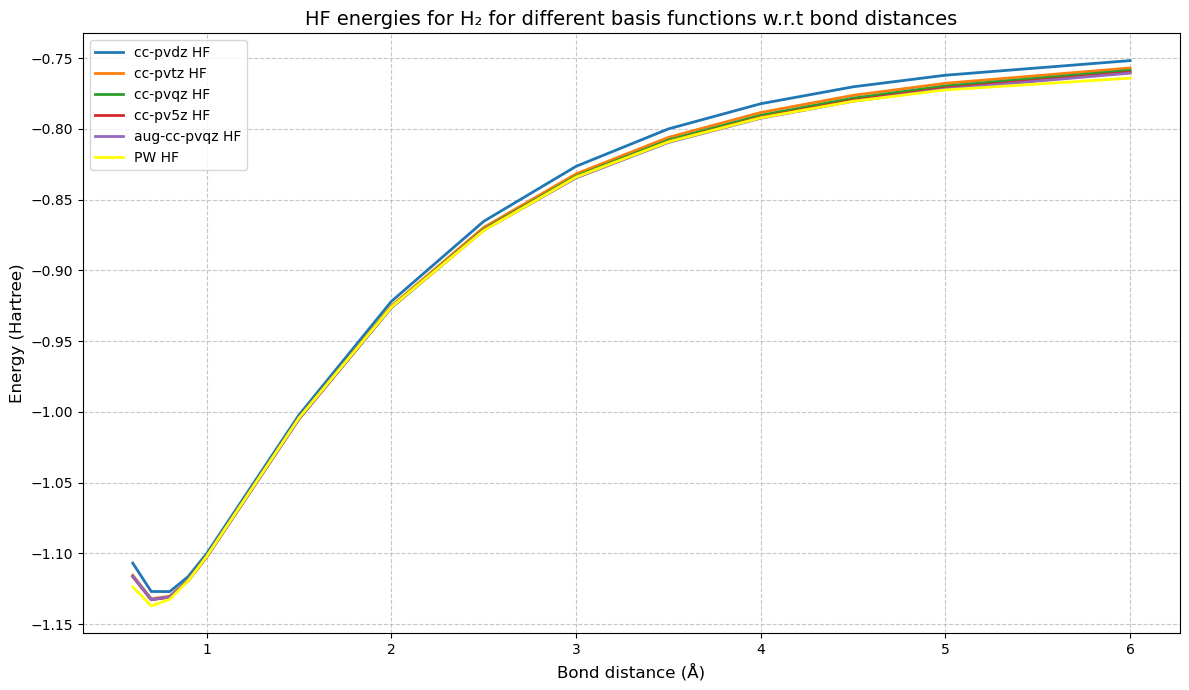

In [19]:
import json
import matplotlib.pyplot as plt
import numpy as np



bases = list(energies_h2_atomic.keys())  

distancias = [float(d) for d in energies_h2_atomic[bases[0]].keys()]
distancias.sort()  # Ordenar numéricamente

plt.figure(figsize=(12, 7))

for i, base in enumerate(bases):
    energias_hf = [energies_h2_atomic[base][str(d)]["HF"] for d in distancias]
    #energias_fci = [energies_h2_atomic[base][str(d)]["FCI"] for d in distancias]
    
    plt.plot(distancias, energias_hf, label=f"{base} HF", linewidth=2)
    
    #plt.plot(distancias, energias_fci, label=f"{base} FCI", linewidth=2)

plt.plot(distancias, energies_PW_H2_HF['0covo'][1], color='yellow', label="PW HF", linewidth=2)
plt.xlabel("Bond distance (Å)", fontsize=12)
plt.ylabel("Energy (Hartree)", fontsize=12)
plt.title("HF energies for H₂ for different basis functions w.r.t bond distances", fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.xlim(min(distancias), max(distancias))
#plt.ylim(-2.0, -0.5)  # Descomenta y ajusta si necesitas
plt.tight_layout()
plt.savefig("energies_hf_h2_covo.png", dpi=300, bbox_inches='tight')
plt.show()

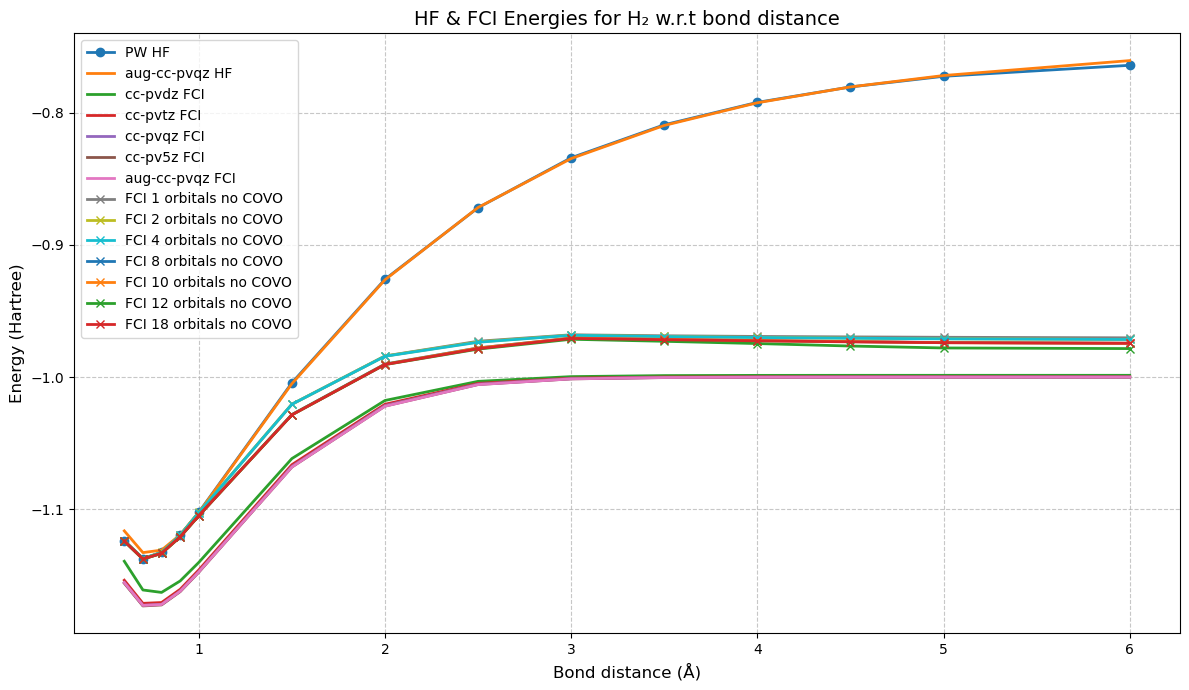

In [10]:

plt.figure(figsize=(12, 7))


plt.plot(distancias, energies_PW_H2_HF['0covo'][1], 'o-', label="PW HF", linewidth=2)

energia_hf = [energies_h2_atomic['aug-cc-pvqz'][str(d)]["HF"] for d in distancias]
plt.plot(distancias, energia_hf, label=f"{'aug-cc-pvqz'} HF", linewidth=2)

for i, base in enumerate(bases):

    energias_fci = [energies_h2_atomic[base][str(d)]["FCI"] for d in distancias]
    plt.plot(distancias, energias_fci, label=f"{base} FCI", linewidth=2)
    
for covo in energies_covo_H2:
    plt.plot(energies_covo_H2[covo][0], energies_nocovo_H2_FCI[covo][1] ,'x-', label=f'FCI {covo} orbitals no COVO', linewidth=2)

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('HF & FCI Energies for H₂ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("energies_fci_h2_nocovo.png", dpi=300, bbox_inches='tight')
plt.show()

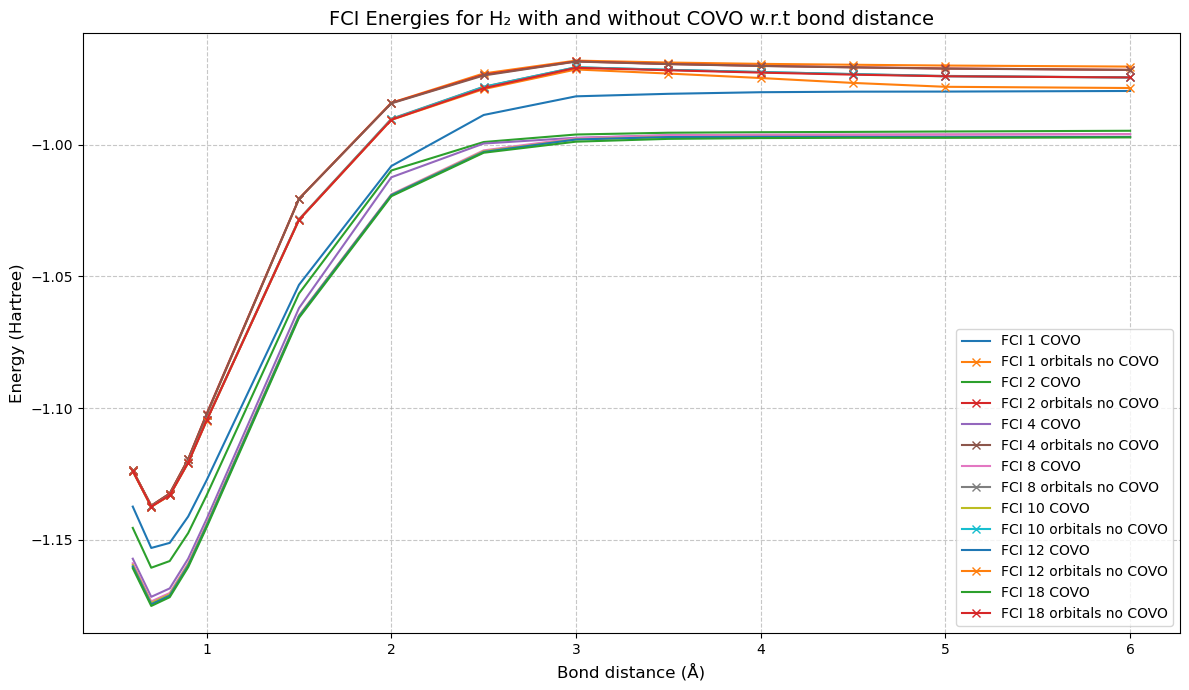

In [11]:
plt.figure(figsize=(12, 7))

for covo in energies_covo_H2:
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], label=f'FCI {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_nocovo_H2_FCI[covo][1] ,'x-', label=f'FCI {covo} orbitals no COVO')

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for H₂ with and without COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("energies_fci_h2_covo.png", dpi=300, bbox_inches='tight')
plt.show()


KeyError: 'CASSCF_12'

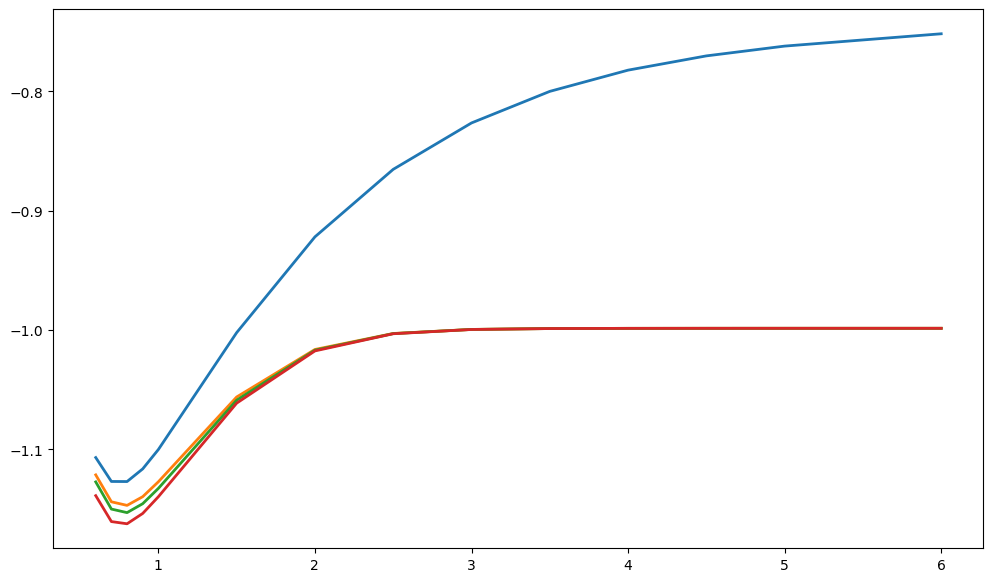

In [21]:
plt.figure(figsize=(12, 7))

for i, base in enumerate(bases):
    for ncas in [1, 2, 4, 8, 12, 18]:
        energias_casscf = [energies_h2_atomic[base][str(d)][f"CASSCF_{ncas}"] for d in distancias]
        plt.plot(distances, energias_casscf, label=f"CASSCF({ncas})", linewidth=2)

for covo in energies_covo_H2:
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], marker='o', label=f'FCI {covo} COVO')  

energia_fci = [energies_h2_atomic['aug-cc-pvqz'][str(d)]["FCI"] for d in distancias]
plt.plot(distancias, energia_fci, 's', label=f"{'aug-cc-pvqz'} FCI", linewidth=2)   

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for H₂ with COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.177,-1.05])
#plt.xlim([0.5,1.5])
#plt.ylim([-1.05,-0.970])
#plt.xlim([1.5,3.0])
plt.ylim([-1.001,-0.979])
plt.xlim([3.0,6.0])
plt.tight_layout()
plt.savefig("energies_casscf_h2_covo_zoom.png", dpi=300, bbox_inches='tight')
plt.show()

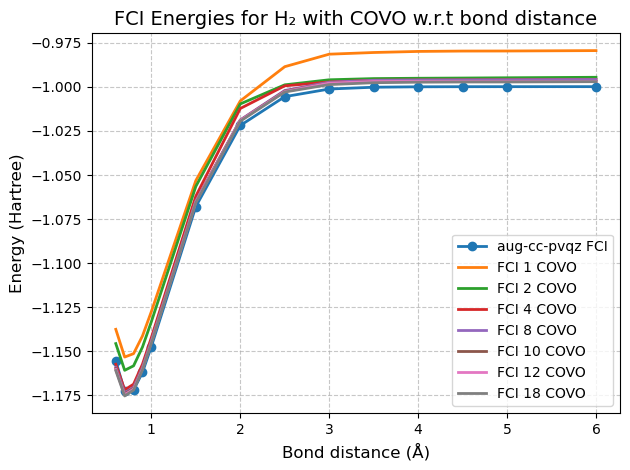

In [15]:

energia_fci = [energies_h2_atomic['aug-cc-pvqz'][str(d)]["FCI"] for d in distancias]
plt.plot(distancias, energia_fci, 'o-', label=f"{'aug-cc-pvqz'} FCI", linewidth=2)

for covo in energies_covo_H2:
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], label=f'FCI {covo} COVO', linewidth=2)

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI Energies for H₂ with COVO w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.177,-1.05])
#plt.xlim([0.5,1.5])
#plt.ylim([-1.05,-0.970])
#plt.xlim([1.5,3.0])
#plt.ylim([-1.001,-0.979])
#plt.xlim([3.0,6.0])
plt.tight_layout()
plt.savefig("energies_fci_h2_covo_zoom.png", dpi=300, bbox_inches='tight')
plt.show()


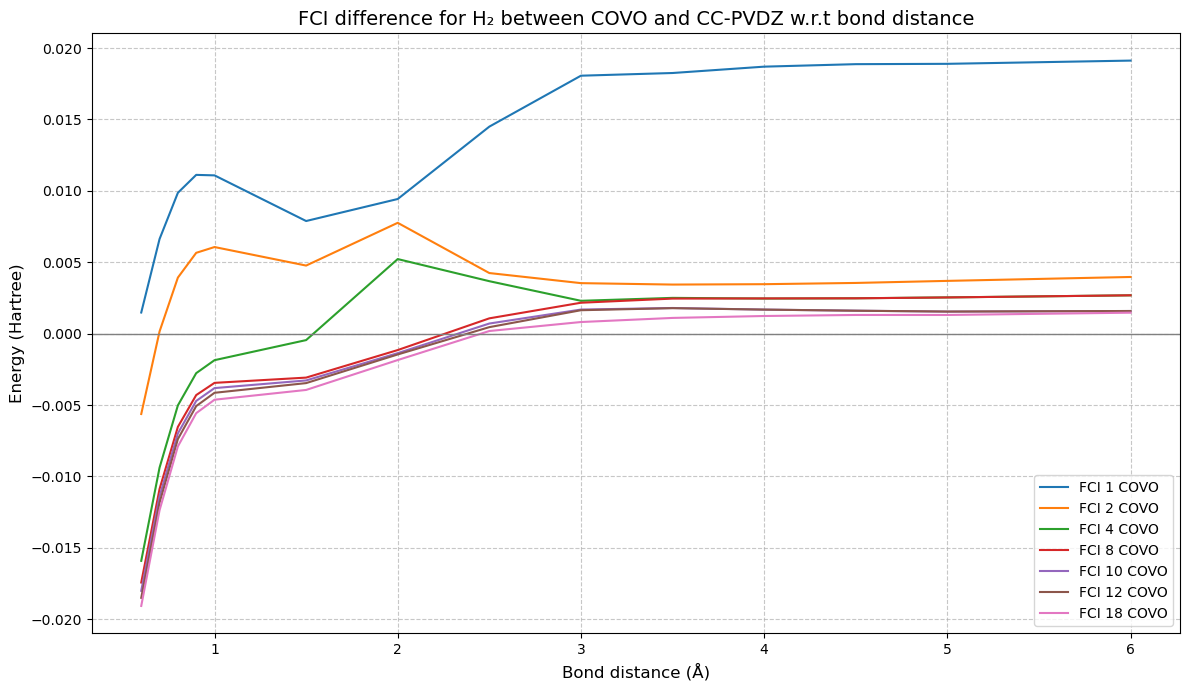

In [20]:
errors_uccsd_H2 = {}
errors_fci_H2 = {}

energia_fci = [energies_h2_atomic['cc-pvdz'][str(d)]["FCI"] for d in distancias]
energia_fci=np.array(energia_fci)
plt.figure(figsize=(12, 7))

for covo in energies_covo_H2:
    errors_fci_H2[covo] = (energies_covo_H2[covo][2] - energia_fci)/np.abs(energia_fci)
    plt.plot(energies_covo_H2[covo][0], errors_fci_H2[covo],  label=f'FCI {covo} COVO')  

plt.axhline(0, color='gray', linestyle='-', linewidth=1) 

plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('FCI difference for H₂ between COVO and CC-PVDZ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.18,-0.8])
plt.tight_layout()
plt.savefig("error_covo_pvdz_H2.png", dpi=300, bbox_inches='tight')
plt.show()


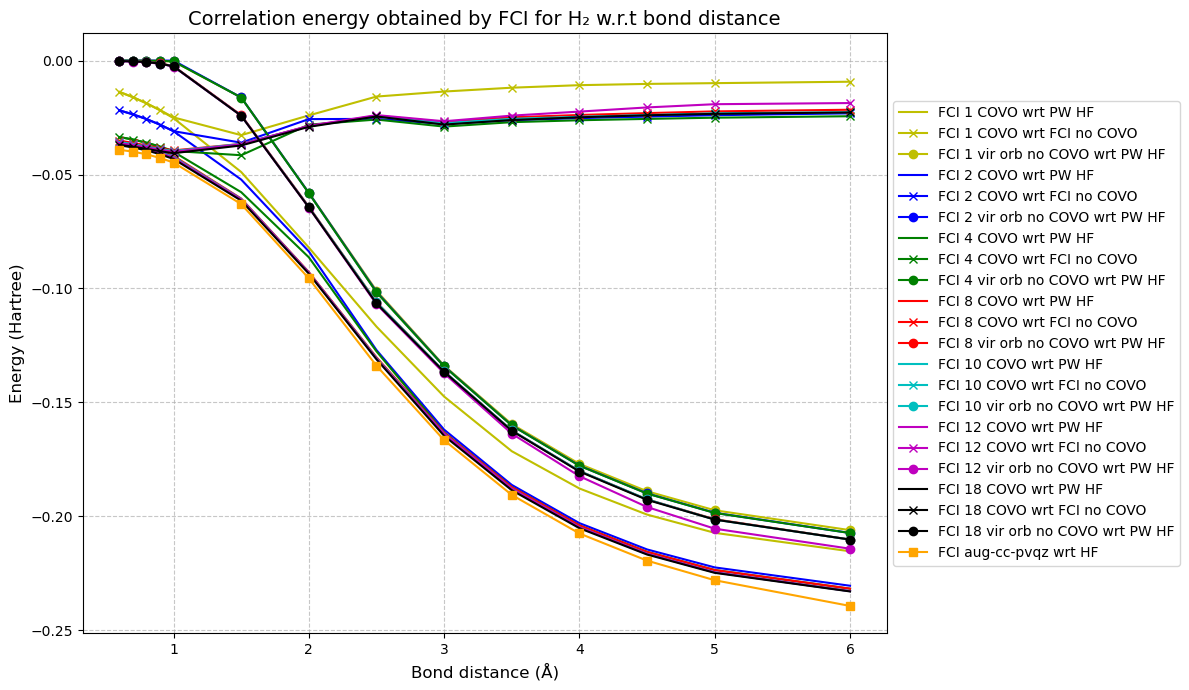

In [25]:
colors = ['y','b','g','r','c','m','k']
plt.figure(figsize=(12, 7))
distancias = [float(d) for d in energies_h2_atomic[bases[0]].keys()]
distancias.sort()  # Ordenar numéricamente
for i,covo in enumerate (energies_covo_H2):
    plt.plot(energies_covo_H2[covo][0], np.array(energies_covo_H2[covo][2]) - energies_PW_H2_HF['0covo'][1],color=colors[i], label = f'FCI {covo} COVO wrt PW HF')
    plt.plot(energies_covo_H2[covo][0], np.array(energies_covo_H2[covo][2]) - energies_nocovo_H2_FCI[covo][1],color=colors[i], marker='x', label = f'FCI {covo} COVO wrt FCI no COVO')
    plt.plot(energies_covo_H2[covo][0], np.array(energies_nocovo_H2_FCI[covo][1]) - energies_PW_H2_HF['0covo'][1],color=colors[i], marker='o', label = f'FCI {covo} vir orb no COVO wrt PW HF')
    
plt.plot(energies_covo_H2[covo][0], np.array([energies_h2_atomic[base][str(d)]["FCI"] for d in distancias]) - [energies_h2_atomic['aug-cc-pvqz'][str(d)]["HF"] for d in distancias], color='orange', marker='s',label='FCI aug-cc-pvqz wrt HF')

plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('Correlation energy obtained by FCI for H₂ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.001,-0.979])
#plt.xlim([2.0,6.0])
plt.savefig('correlation_covo_H2.png',dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


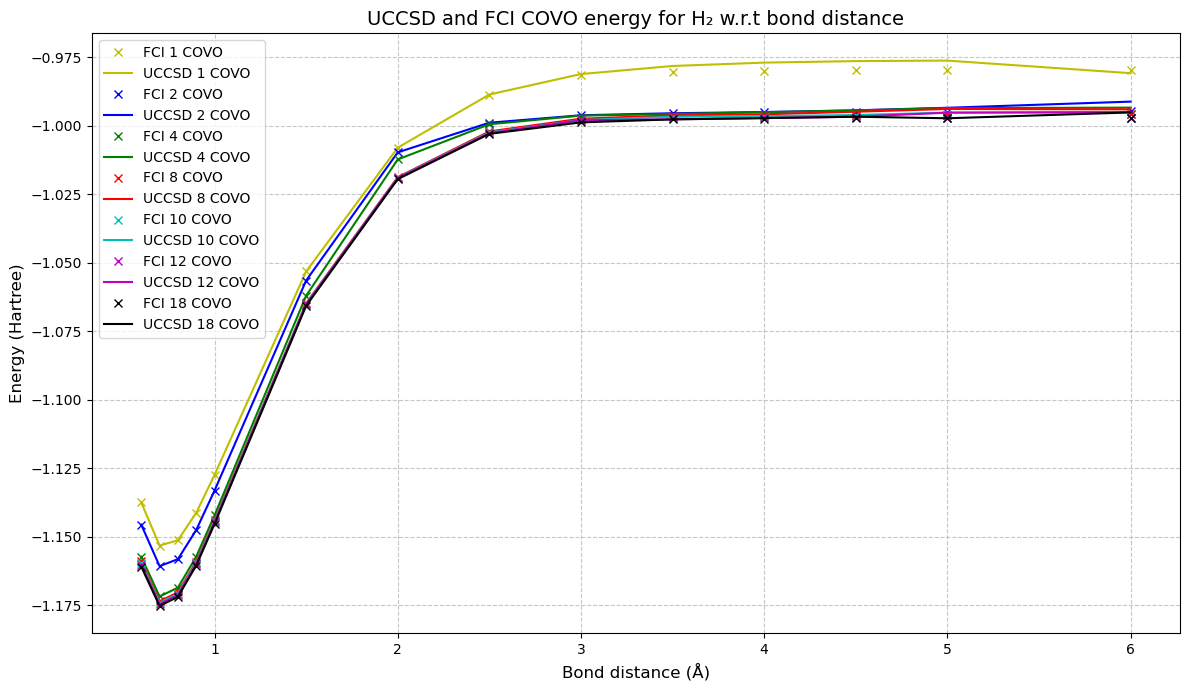

In [18]:

plt.figure(figsize=(12, 7))
colors = ['y','b','g','r','c','m','k']
for i,covo in enumerate (energies_covo_H2):
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], color=colors[i],linestyle='', marker='x', label = f'FCI {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], color=colors[i], label = f'UCCSD {covo} COVO')

plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('UCCSD and FCI COVO energy for H₂ w.r.t bond distance',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.ylim([-1.001,-0.979])
#plt.xlim([2.0,6.0])
plt.savefig('energy_fci_uccsd_covo_H2.png')
plt.tight_layout()
plt.show()


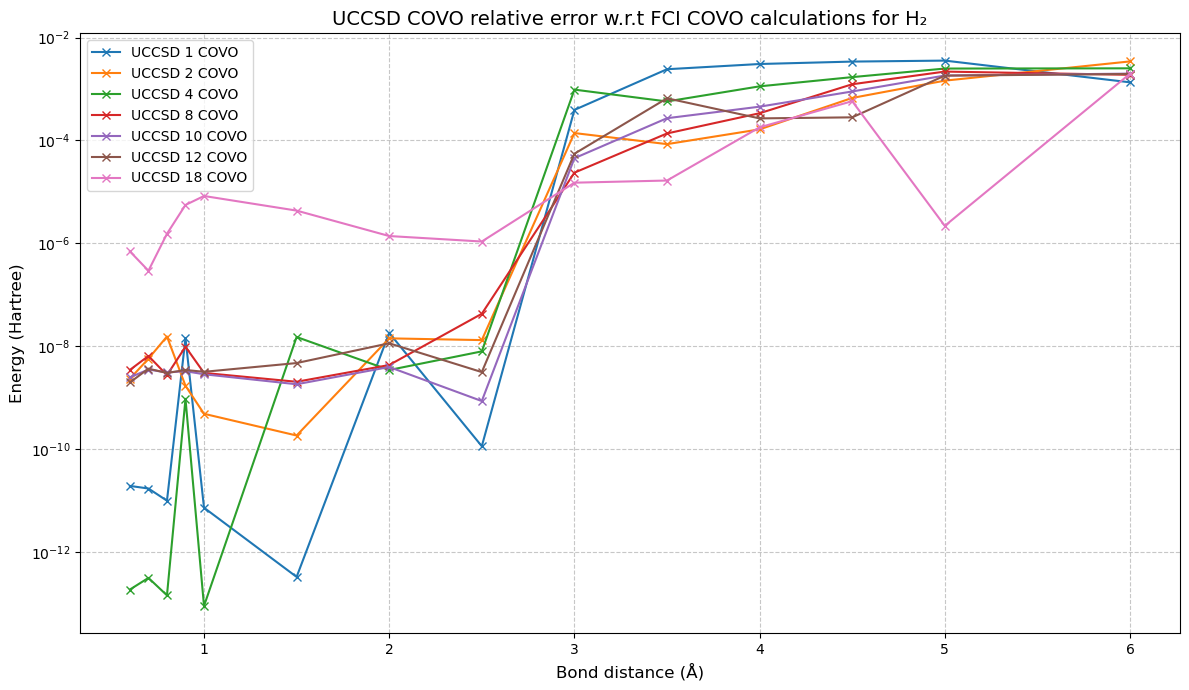

In [19]:
error_covos = {}

for covo in energies_covo_H2:
    
    energy_covo_uccsd = np.array(energies_covo_H2[covo][1])
    energy_covo_fci = np.array(energies_covo_H2[covo][2])
    
    error_covos[covo] = np.abs(energy_covo_uccsd - energy_covo_fci)/np.abs(energy_covo_fci)
plt.figure(figsize=(12, 7))
    
for covo in energies_covo_H2:
    plt.semilogy(energies_covo_H2[covo][0], error_covos[covo], 'x-', label = f'UCCSD {covo} COVO')
plt.grid(True)
plt.xlabel('Bond distance (Å)', fontsize=12)
plt.ylabel('Energy (Hartree)',fontsize=12)
plt.title('UCCSD COVO relative error w.r.t FCI COVO calculations for H₂',fontsize=14)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('error_covo_uccsd_H2.png')
plt.tight_layout()
plt.show()

